# IMPORTING MODULES AND METHODS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.simplefilter("ignore")

# Reading 'train.csv'

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Section,Label
0,Description ÛÏJacobs National Security Soluti...,3
1,Duties will include Applying complex analysis ...,5
2,Job Qualifications Active Top Secret security ...,6
3,Essential Functions,5
4,Other Essential Functions Must be able to comm...,5


In [4]:
df = df[pd.notnull(df.Label)]

# Showing bar-graph of count of each class

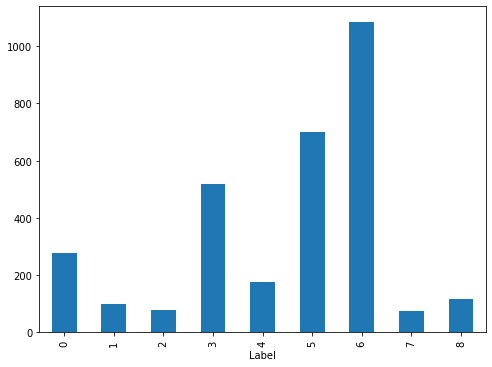

In [5]:
fig = plt.figure(figsize=(8,6))
df.groupby('Label').Label.count().plot.bar(ylim=0)
plt.show()

In [6]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
fitted_vectorizer = tfidf.fit(df.Section)
features = fitted_vectorizer.transform(df.Section).toarray()
labels = df.Label
print(features.shape)

(3125, 11070)


#  Finding most common unigrams and diagrams

In [7]:
N = 2
for label in range(9):
  features_chi2 = chi2(features, labels == label)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("## {} ##".format(label))
  print("  (1) Most correlated unigrams:\n      -> {}".format('\n      -> '.join(unigrams[-N:])))
  print("  (2) Most correlated bigrams:\n      -> {}".format('\n   -> '.join(bigrams[-N:])))

## 0 ##
  (1) Most correlated unigrams:
      -> desired
      -> preferred
  (2) Most correlated bigrams:
      -> desired skills
   -> preferred qualifications
## 1 ##
  (1) Most correlated unigrams:
      -> com
      -> www
  (2) Most correlated bigrams:
      -> equal opportunity
   -> opportunity employer
## 2 ##
  (1) Most correlated unigrams:
      -> engineer
      -> title
  (2) Most correlated bigrams:
      -> title information
   -> job title
## 3 ##
  (1) Most correlated unigrams:
      -> summary
      -> description
  (2) Most correlated bigrams:
      -> job summary
   -> job description
## 4 ##
  (1) Most correlated unigrams:
      -> washington
      -> location
  (2) Most correlated bigrams:
      -> united states
   -> primary location
## 5 ##
  (1) Most correlated unigrams:
      -> duties
      -> responsibilities
  (2) Most correlated bigrams:
      -> responsibilities include
   -> duties responsibilities
## 6 ##
  (1) Most correlated unigrams:
      -> experie

# Comparing classification model accuracy

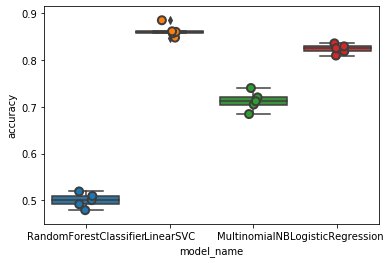

In [8]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [9]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.862701
LogisticRegression        0.823997
MultinomialNB             0.712608
RandomForestClassifier    0.500204
Name: accuracy, dtype: float64

# Testing on Cross-Validation dataset

In [10]:
model = LinearSVC()

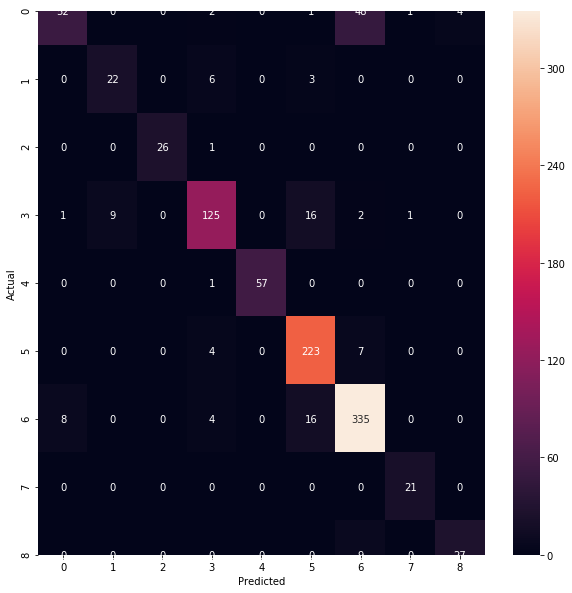

In [11]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(range(9)), yticklabels=list(range(9)))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Testing on 'valid.csv'

In [12]:
df_valid = pd.read_csv('valid.csv')

In [13]:
features = tfidf.transform(df_valid.Section).toarray()
labels = df_valid.Label
features.shape

(782, 11070)

In [14]:
y_pred = model.predict(features)

In [15]:
conf_mat = confusion_matrix(labels, y_pred)

In [16]:
print('Precision','Recall','f1-Score','Support')
print(precision_recall_fscore_support(labels, y_pred, average='macro'))

Precision Recall f1-Score Support
(0.9245578678035202, 0.86094658143393, 0.8878352507823432, None)
